<a target="_blank" href="https://colab.research.google.com/github/gena/next25-weather/notebooks/weathernext-bigquery-simple.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Exploring Global Weather Forecasts with Earth Engine and WeatherNext 2

**Welcome!** This notebook introduces a weather forecast dataset available in Earth Engine, generated by Google DeepMind and Google Research's WeatherNext 2 model. Through a series of sample queries, we'll demonstrate how to access, analyze, and visualize this data to gain insights into global weather patterns, trends, and potential impacts.

**Dataset Overview**

This dataset offers weather forecasts produced by WeatherNext, a state-of-the-art machine learning model developed by Google DeepMind and Google Research. It provides predictions for various weather variables, including temperature, precipitation, wind speed, and more, at a global scale and with a high degree of accuracy. Each forecast consists of 64 ensemble members, representing 64 different possible outcomes.

**Notebook Purpose**

This notebook aims to:

* Familiarize users with the structure and content of the WeatherNext 2 weather forecast dataset in Earth Engine.
* Demonstrate how to query and analyze this data using Earth Engine's powerful tools and functions.
* Showcase the potential applications of this data for various weather-related tasks, such as forecasting, climate analysis, and risk assessment.

**Copyright Information**

Copyright 2025 Google LLC. All materials are licensed under the [Creative Commons Attribution 4.0 International License (CC-BY)](https://creativecommons.org/licenses/by/4.0/legalcode).

[Earth Engine Client Library Documentation](https://developers.google.com/earth-engine/apidocs)

## Import Python Libraries & Some Other Setup

In [ ]:
from collections.abc import Mapping

import ee
import geemap.core as geemap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

import warnings
# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

## Set Google Cloud/Earth Engine Project ID

In [ ]:
project_id = 'anthromet-prod'  #@param{type:"string"}
ee.Authenticate()
ee.Initialize(project=project_id)
ee_image_collection = 'projects/gcp-public-data-weathernext/assets/weathernext_2_0_0'  #@param{type:"string"}

# Utility functions

In [ ]:
def convert_to_dataframe(
    image_collection: ee.ImageCollection,
    geometry: ee.Geometry,
    bands_to_reducer: Mapping[str, ee.Reducer]
):
  """Converts an EE ImageCollection into a Pandas Dataframe. For plotting."""
  covering_grid = geometry.coveringGrid(
      image_collection.first().projection(),
      image_collection.first().projection().nominalScale()
  )

  def convert_to_feature_collection(image: ee.Image):
    def get_feature_for_cell(cell_polygon: ee.Geometry.Polygon):
      feature_dict = {
          'time': image.get('end_time'),
          'init_time': image.get('start_time'),
          'ensemble_member': image.get('ensemble_member')
      }
      # Add each of the band values to the feature dict. Use the supplied
      # reducer method to get this value (typically, mean).
      for band_id, reducer in bands_to_reducer.items():
        value = image.reduceRegion(
            reducer=reducer,
            geometry=cell_polygon.geometry(),
            scale=image.projection().nominalScale()
        ).get(band_id)
        feature_dict[band_id] = value
      return ee.Feature(cell_polygon.geometry(), feature_dict)
    return covering_grid.map(get_feature_for_cell)

  features = image_collection.map(convert_to_feature_collection).flatten()
  df = ee.data.computeFeatures(
      {'expression': features, 'fileFormat': 'PANDAS_DATAFRAME'}
  )
  df['time'] = pd.to_datetime(df['time'])
  df['init_time'] = pd.to_datetime(df['init_time'])
  return df

# Weather Forecast Dataset Schema

This describes the schema for a weather forecast dataset. In Earth Engine, it consists of an ImageCollection where each Image represents a prediction for a given init time and valid time (see Image Properties below). There are 64 Images (ensemble members) sharing the same init time and valid time. The Image has bands containing the predicted values.

## Image Properties

<div align="left">

| Name | Type | Description |
| --- | --- | --- |
| `start_time` | STRING | The initialization time of the forecast. |
| `end_time` | STRING | The valid time for this specific forecast. Calculated as start_time + forecast_hour. |
| `forecast_hour` | INT | The forecast lead time in hours. Represents the number of hours from the start_time. |
| `ingestion_time` | DOUBLE | The time when this forecast data became available in Earth Engine. |
| `ensemble_member` | STRING | The ID of the member in the ensemble. |

</div>

## Bands

<div align="left">

| Name | Units | Pixel Size | Description |
|---|---|---|---|
| `total_precipitation_6hr` | m | meters | Total precipitation over a 6-hour period |
| `10m_u_component_of_wind` | m/s | meters | The u-component of wind at 10 meters above the surface |
| `10m_v_component_of_wind` | m/s | meters | The v-component of wind at 10 meters above the surface |
| `100m_u_component_of_wind` | m/s | meters | The u-component of wind at 100 meters above the surface |
| `100m_v_component_of_wind` | m/s | meters | The v-component of wind at 100 meters above the surface |
| `2m_temperature` | K | meters | Temperature at 2 meters above the surface |
| `mean_sea_level_temperature` | Pa | meters | Mean sea level pressure |
| `sea_surface_temperature` | K | meters |Sea surface temperature |

There are also bands for the following variables at various pressure levels (50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000 hPa):

| Name | Units | Pixel Size | Description |
|---|---|---|---|
| `*_geopotential` | m^2/s^2 | meters | Geopotential height |
| `*_specific_humidity` | kg/kg | meters | Specific humidity |
| `*_temperature` | K | meters | Temperature |
| `*_u_component_of_wind` | m/s | meters | The u-component of wind |
| `*_v_component_of_wind` | m/s | meters | The v-component of wind |
| `*_vertical_velocity` | Pa/s | meters | Vertical velocity |

</div>

# Example Queries

## Exploring Temperature Forecasts for New York City - 5 Day

This query retrieves the 2-meter temperature forecasts for New York, NY, demonstrating how to access and analyze the core weather data in the table.


In [ ]:
ny_geom = ee.Geometry.Polygon(
    [-70.66, 40.64, -73.85, 40.64, -73.85, 40.89, -70.66, 40.89, -70.66, 40.64]
)
ny_temps_ee = (ee.ImageCollection(ee_image_collection)
  .filter(ee.Filter.eq('start_time', '2022-10-01T06:00:00Z'))
  .filterBounds(ny_geom)
  # Passing all 64 ensemble members to convert_to_dataframe is too slow for
  # Colab, so let's just work with the first 10 members.
  # To work with tabular data, BigQuery is much faster.
  .filter(ee.Filter.lt('ensemble_member', '10'))
  .select('2m_temperature'))

# Convert to Pandas dataframe for graphing purposes.
ny_temps = convert_to_dataframe(
    ny_temps_ee, ny_geom, {'2m_temperature': ee.Reducer.mean()}
)

# Show data
ny_temps

geo  2m_temperature  \
0     {'type': 'Polygon', 'coordinates': [[[-74, 40....      286.287659   
1     {'type': 'Polygon', 'coordinates': [[[-73.75, ...      284.532776   
2     {'type': 'Polygon', 'coordinates': [[[-73.5, 4...      286.639984   
3     {'type': 'Polygon', 'coordinates': [[[-73.25, ...      287.176025   
4     {'type': 'Polygon', 'coordinates': [[[-73, 40....      286.748352   
...                                                 ...             ...   
3355  {'type': 'Polygon', 'coordinates': [[[-71.75, ...      291.305695   
3356  {'type': 'Polygon', 'coordinates': [[[-71.5, 4...      291.468384   
3357  {'type': 'Polygon', 'coordinates': [[[-71.25, ...      291.554993   
3358  {'type': 'Polygon', 'coordinates': [[[-71, 40....      291.376282   
3359  {'type': 'Polygon', 'coordinates': [[[-70.75, ...      290.886536   

     ensemble_member                 init_time                      time  
0                  0 2022-10-01 06:00:00+00:00 2022-10-01 12:00:00+00:00  
1                  0 2022-10-01 06:00:00+00:00 2022-10-01 12:00:00+00:00  
2                  0 2022-10-01 06:00:00+00:00 2022-10-01 12:00:00+00:00  
3                  0 2022-10-01 06:00:00+00:00 2022-10-01 12:00:00+00:00  
4                  0 2022-10-01 06:00:00+00:00 2022-10-01 12:00:00+00:00  
...              ...                       ...                       ...  
3355               1 2022-10-01 06:00:00+00:00 2022-10-16 06:00:00+00:00  
3356               1 2022-10-01 06:00:00+00:00 2022-10-16 06:00:00+00:00  
3357               1 2022-10-01 06:00:00+00:00 2022-10-16 06:00:00+00:00  
3358               1 2022-10-01 06:00:00+00:00 2022-10-16 06:00:00+00:00  
3359               1 2022-10-01 06:00:00+00:00 2022-10-16 06:00:00+00:00  

[3360 rows x 5 columns]

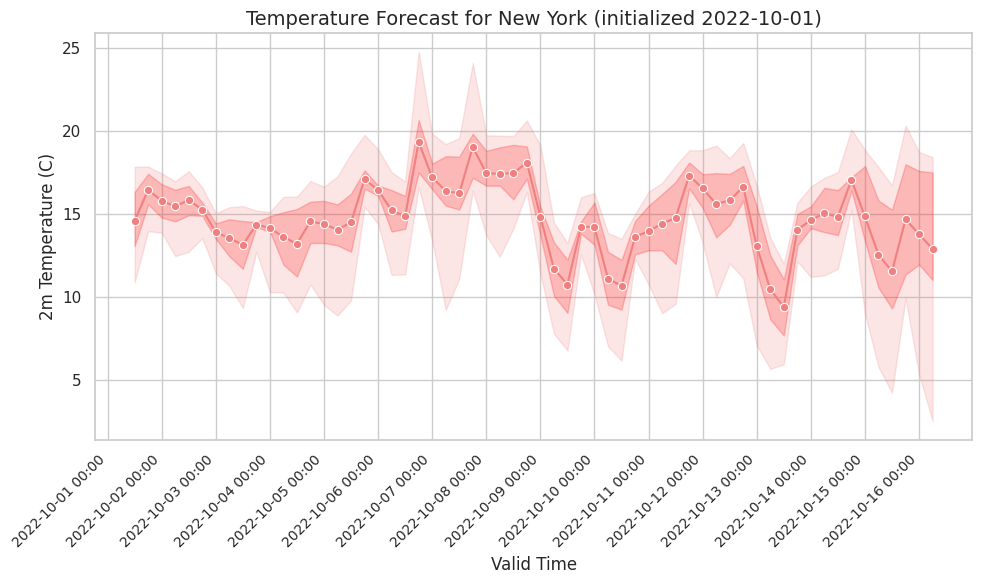

In [ ]:
# Extract the date from the first entry's init_time.
forecast_date = ny_temps['init_time'].iloc[0].strftime('%Y-%m-%d')

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Plot the data
# This will display a graph with a line representing the average temp, and
# error bars representing the min and max for each forecast time.
# The average temp is the average across all ensembles AND all polygons inside
# NYC.
# The average is implicitly calculated by the plotting library.

plt.figure(figsize=(10, 6))

# Avg with min and max band
def min_max_err(x):
  return (x.min(), x.max())
sns.lineplot(
    x=mdates.date2num(ny_temps['time'].dt.to_pydatetime()),
    y=ny_temps['2m_temperature'] - 273.15,
    errorbar=min_max_err,
    marker='o',
    linestyle='-',
    color='lightcoral'
)

# 50th percentile band
sns.lineplot(
    x=mdates.date2num(ny_temps['time'].dt.to_pydatetime()),
    y=ny_temps['2m_temperature'] - 273.15,
    errorbar=('pi', 50),
    marker='',
    linestyle='',
    color='red'
)

plt.xlabel('Valid Time', fontsize=12)
plt.ylabel('2m Temperature (C)', fontsize=12)
plt.title(f'Temperature Forecast for New York (initialized {forecast_date})', fontsize=14)

# Format the x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Show date and time
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks for each day
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()

## Deterministic forecasts

The forecasts produced by WeatherNext 2 consist of ensembles. To get a single deterministic forecast, you can average the values across all the ensembles, as in the following example:

### World - 10/03/2025 06:00 Hours
This query gets the values for a variable averaged over all ensemble members in a single forecast (specifically, with an init time of 2025-10-02 18:00 and valid time of 2025-10-03 00:00).

In contrast to the previous example, the average is calculated using Earth Engine client library operations instead of implicitly by the graphing library.

In [ ]:
# Map display options
variable = "2m_temperature" # @param ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind", "mean_sea_level_pressure", "sea_surface_temperature", "total_precipitation_6hr"]
palette = "coolwarm"  # @param ["coolwarm", "Spectral_r", "BuPu"]
pixelated = False  # @param {type:"boolean"}

world_avgs = (ee.ImageCollection(ee_image_collection)
  .filter(ee.Filter.eq('start_time', '2025-10-02T18:00:00Z'))
  .filter(ee.Filter.eq('end_time', '2025-10-03T00:00:00Z'))
  .select(variable)
  .reduce(ee.Reducer.mean()))
if (not pixelated):
  world_avgs = world_avgs.resample('bicubic')

min_max = (world_avgs
  .reduceRegion(
      reducer=ee.Reducer.minMax(),
      geometry=ee.Geometry.BBox(-180, -90, 180, 90),  # Global geometry
      scale=world_avgs.projection().nominalScale(),
      maxPixels=1e13
  )
)

vis_params = {
    'bands': [f'{variable}_mean'],
    'min': min_max.get(f'{variable}_mean_min'),
    'max': min_max.get(f'{variable}_mean_max'),
    'palette': palette,
}

m = geemap.Map(center=[35, 0], zoom=2)
m.add_layer(world_avgs, vis_params, f'{variable} average', True, 0.5)
m

Map(center=[35, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…